## Introduction
This project aims to develop a robust natural language processing (NLP) model to automatically identify and classify disaster-related tweets. By leveraging Recurrent Neural Network (RNN) modeling techniques, we can effectively analyze the textual content of tweets and distinguish between those that refer to real disasters and those that do not.

The primary objective of this project is to provide an automated and reliable solution for disaster response teams, news agencies, and the general public to quickly identify and prioritize disaster-related information from the massive influx of tweets. This will help in streamlining the dissemination of accurate information, facilitating rapid response efforts, and improving overall situational awareness during critical events.

The key steps involved in this project include:

1. Data Collection: Acquiring a labeled dataset of tweets containing disaster-related information. The dataset comprises tweets labeled as either "disaster" or "non-disaster."

2. Data Preprocessing: Cleaning and preprocessing the text data by tokenizing, removing stop words, and converting the text into numerical sequences suitable for input to the RNN model.

3. Model Development: Constructing an RNN model that incorporates an embedding layer, LSTM layer, and dense layer for binary classification of disaster-related tweets. The model will be trained on the labeled dataset, optimizing the parameters to achieve high accuracy and generalizability.

4. Model Evaluation: Assessing the performance of the trained model by evaluating key metrics such as accuracy, precision, recall, and F1 score. Fine-tuning the model and exploring techniques to handle any class imbalance or bias in the dataset.

5. Prediction and Submission: Applying the trained model to predict the disaster classification for a separate test dataset. Generating a submission file containing the tweet IDs and corresponding predictions for further analysis and evaluation.

By accurately classifying disaster-related tweets, this project aims to enhance the effectiveness of disaster response operations, improve crisis communication, and enable informed decision-making during emergency situations. The insights gained from this project can be leveraged by various stakeholders involved in disaster management, including emergency response teams, humanitarian organizations, and policymakers.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

df = pd.read_csv('../input/nlp-getting-started/train.csv')
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

train.head()

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## EDA 

Data exploration is a critical step in understanding the characteristics and nuances of the dataset before building the NLP disaster tweet classification model. During the data exploration phase, it is essential to analyze various aspects of the dataset, such as the distribution of classes (disaster vs. non-disaster tweets), the length of tweets, and the presence of any class imbalances or biases. Exploring the dataset can help identify potential challenges and inform preprocessing decisions, such as handling missing data, removing duplicates, or dealing with noisy or irrelevant tweets. Visualizing the data using techniques like histograms, word clouds, or bar plots can provide valuable insights into the frequency of disaster-related keywords or common phrases, enabling a better understanding of the dataset's content. By thoroughly exploring the data, researchers and practitioners can gain valuable insights into the dataset's characteristics, informing subsequent preprocessing steps and model design choices as shown below in the graphs charts which detail the paramters of the dataset.


<Axes: >

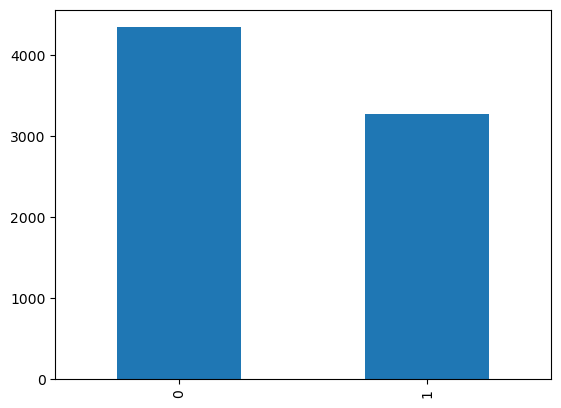

In [3]:
# plot -> label -> classification
train.target.value_counts().plot.bar()


In [4]:
def length(text):
    return len(text)
# new attribute 'length' in train 
train['length'] = train['text'].apply(length)

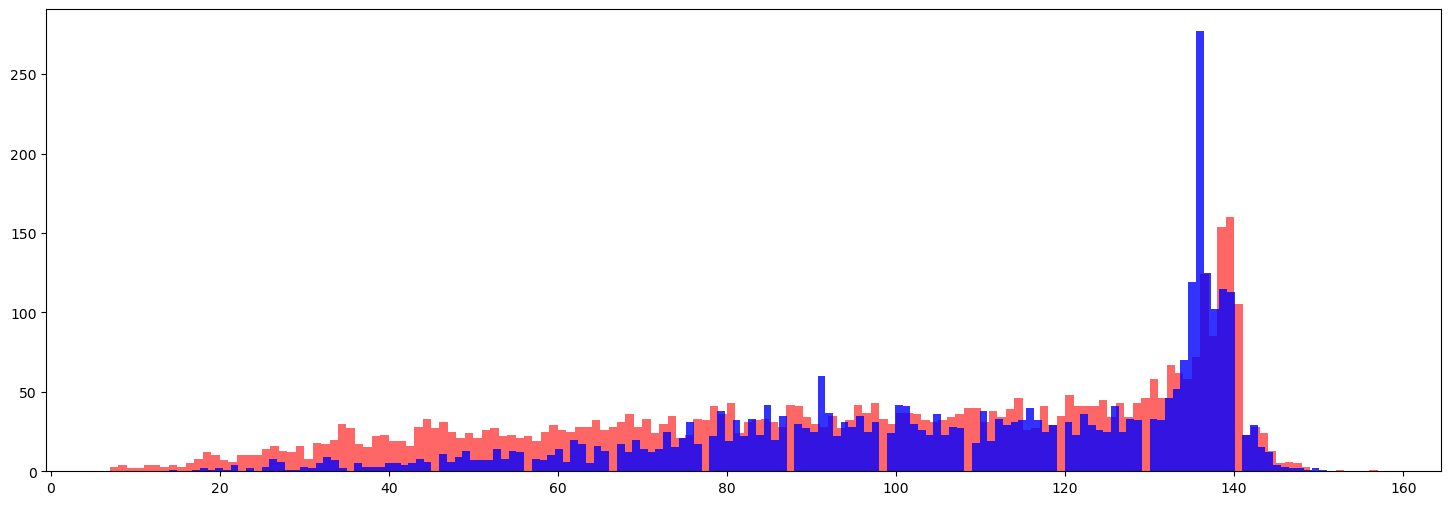

In [5]:
# plot -> value -> length
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(train[train['target'] == 0]['length'], alpha=0.6, bins=bins, label='Not', color='red')
plt.hist(train[train['target'] == 1]['length'], alpha=0.8, bins=bins, label='Real', color='blue')
plt.show()

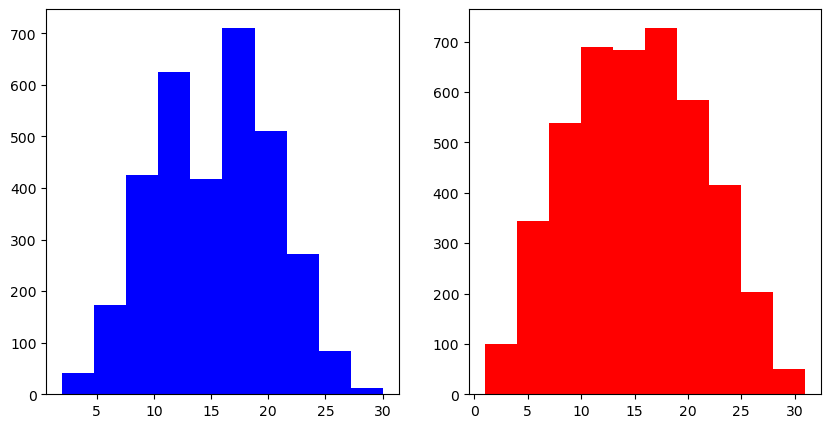

In [6]:
# number of words
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
train_len = train[train['target'] == 1]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_len, color='blue')
train_len = train[train['target'] == 0]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_len, color='red')
plt.show()



/tmp/ipykernel_20/3508455252.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1, color='blue')
/tmp/ipykernel_20/3508455252.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)), ax=ax2, color='red')


<Axes: xlabel='text', ylabel='Density'>

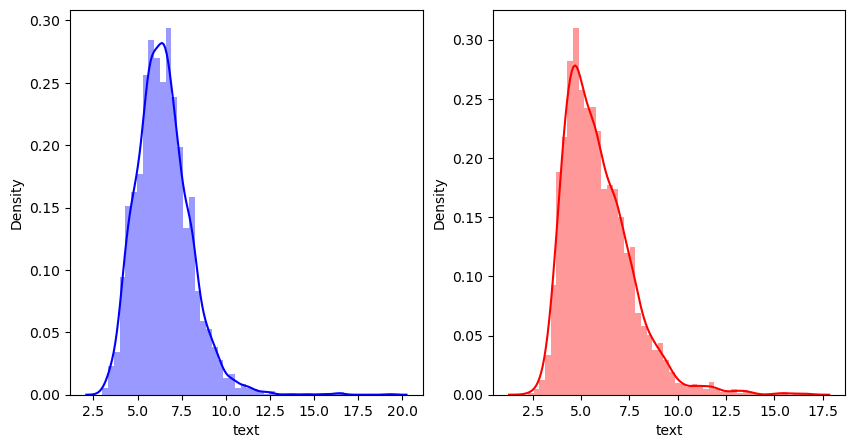

In [7]:
# average length in a text
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
word = train[train['target'] == 1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1, color='blue')
word = train[train['target'] == 0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax2, color='red')



In [8]:
from nltk.corpus import stopwords
# set english
stop = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter
import string
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
 #create corpus to get only corpus
def create_corpus(target):
    corpus = []
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def create_corpus_df(train, target):
    corpus = []
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 10 artists>

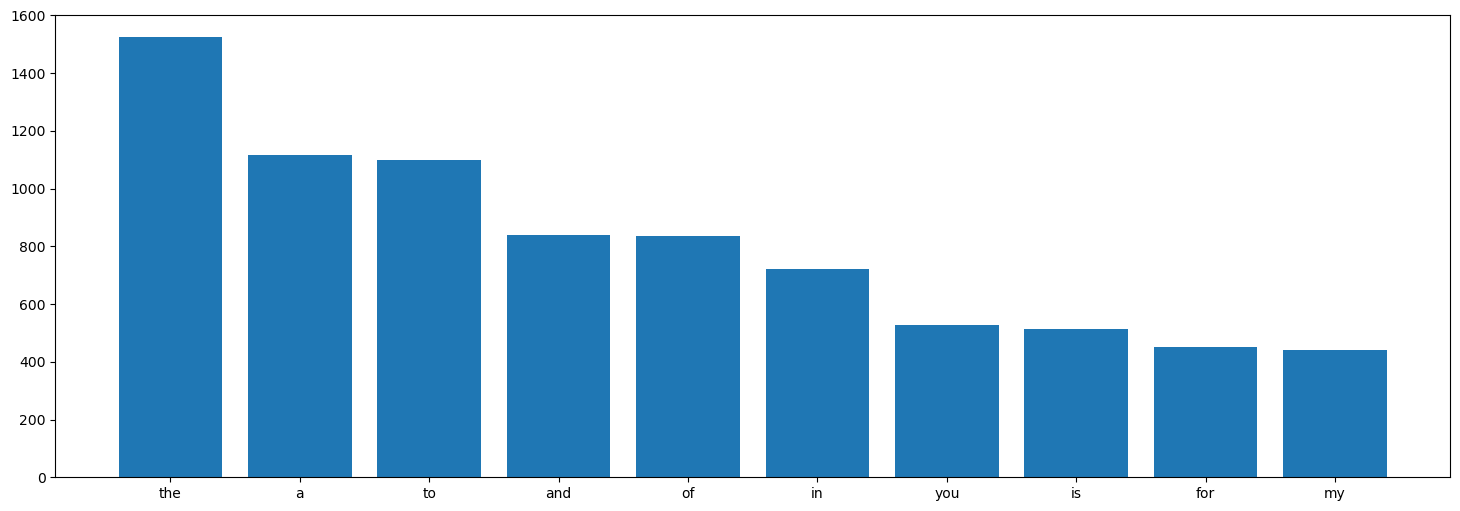

In [10]:
# create corpus 0 => not
corpus = create_corpus(0)
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

# then plot stop words 
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x, y = zip(*top)
plt.bar(x, y)


<BarContainer object of 10 artists>

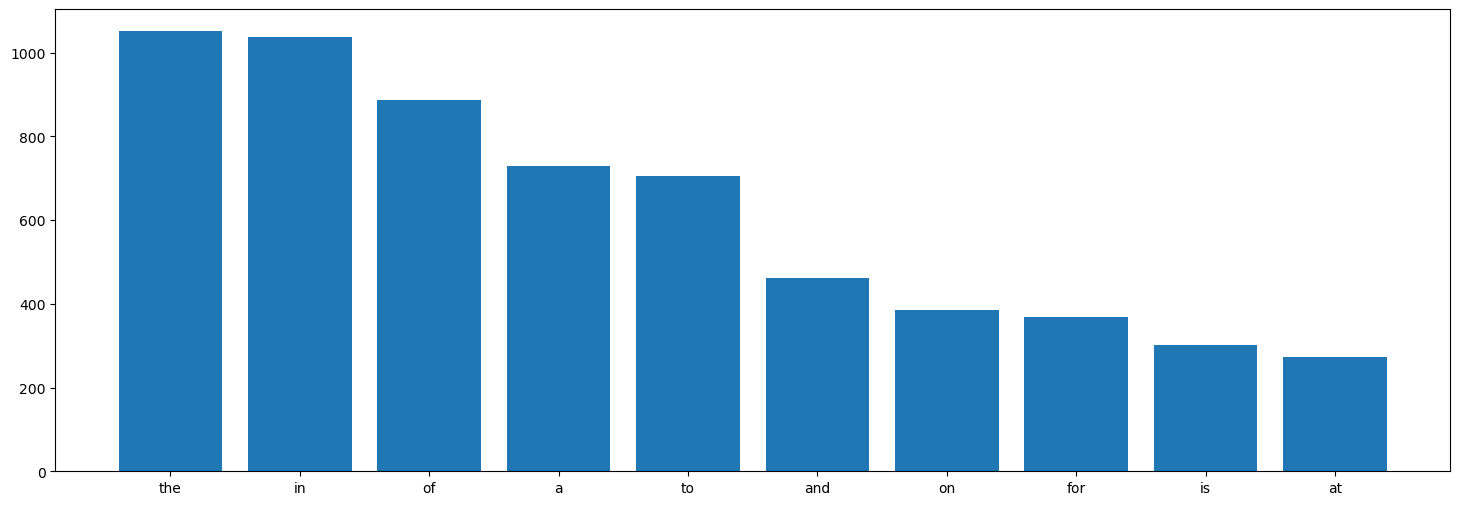

In [11]:
# create corpus 1 => real
corpus = create_corpus(1)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x, y = zip(*top)
plt.bar(x, y)



<BarContainer object of 20 artists>

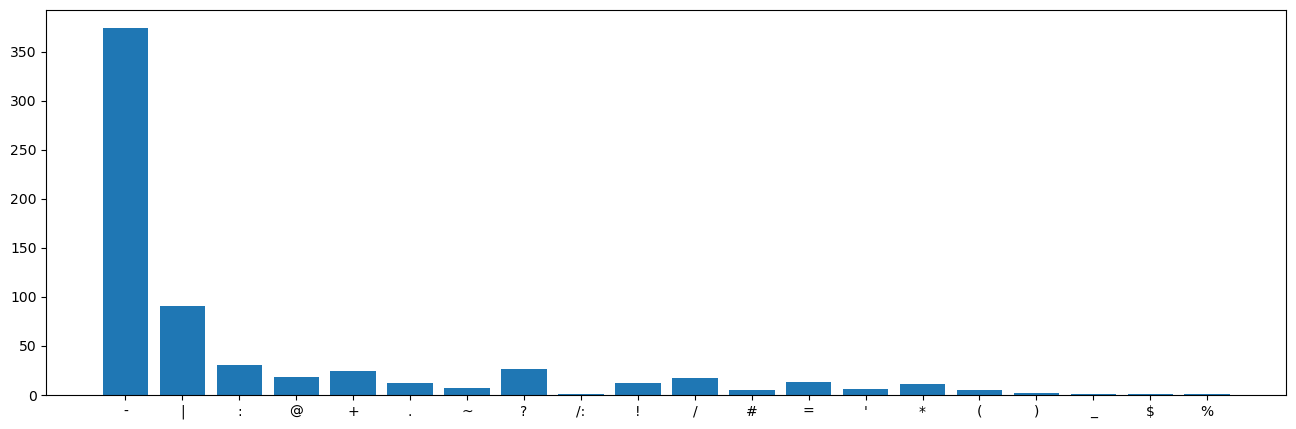

In [12]:
# punctuation 0 => not
plt.figure(figsize=(16, 5))
corpus = create_corpus(0)
dic = defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i] += 1
x, y = zip(*dic.items())
plt.bar(x, y)


## Model Analysis

1. Embedding Layer: The embedding layer is responsible for representing words or tokens in a dense vector space. It maps each word in the input sequence to a high-dimensional vector, where words with similar meanings are closer together in the vector space. This layer helps capture the semantic meaning and contextual information of the words in the tweet texts. By leveraging pre-trained word embeddings or learning embeddings specific to the dataset, the model can benefit from the semantic relationships between words, improving its ability to understand the textual content.

2. LSTM Layer: Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) layer that is well-suited for processing sequential data, such as sentences or text. LSTMs are designed to address the vanishing gradient problem and capture long-term dependencies in the input sequences. In the context of analyzing disaster tweets, LSTMs can effectively capture the temporal dynamics and contextual information present in the text. They are particularly useful for understanding the sequence of words and capturing relationships between different parts of the tweet that contribute to the overall meaning.

3. Dense Layer: The dense layer, also known as the fully connected layer, is responsible for making the final prediction based on the extracted features from the LSTM layer. In this architecture, we use a single dense layer with a sigmoid activation function to perform binary classification, determining whether a tweet is related to a disaster or not. The sigmoid activation function ensures that the output is a probability value between 0 and 1, representing the likelihood of a tweet being a disaster-related tweet.

The reasoning behind this model architecture is to leverage the sequential nature of tweet texts while capturing the semantic meaning and context of the words. The embedding layer helps in transforming the text data into a numerical representation suitable for input to the LSTM layer. The LSTM layer, with its ability to process sequential information, captures the dependencies and patterns within the tweet texts. Finally, the dense layer provides the final classification output based on the learned features from the LSTM layer.

It's important to note that the chosen architecture represents a starting point and can be further optimized or modified based on the specific characteristics of the dataset and the desired performance. Depending on the complexity of the problem and the dataset size, you may consider adding additional layers, increasing the LSTM units, or applying regularization techniques such as dropout or recurrent dropout to improve generalization and mitigate overfitting.

In [13]:
# Preprocess the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, maxlen=100)

# Prepare the target variable
labels = df['target'].values

In [14]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [15]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [16]:
epochs = 10
batch_size = 32

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)


Epoch 1/10
191/191 [==============================] - 41s 192ms/step - loss: 0.5419 - accuracy: 0.7299 - val_loss: 0.4452 - val_accuracy: 0.8076
Epoch 2/10
191/191 [==============================] - 35s 185ms/step - loss: 0.3095 - accuracy: 0.8760 - val_loss: 0.5023 - val_accuracy: 0.7774
Epoch 3/10
191/191 [==============================] - 35s 186ms/step - loss: 0.1447 - accuracy: 0.9453 - val_loss: 0.5923 - val_accuracy: 0.7689
Epoch 4/10
191/191 [==============================] - 35s 184ms/step - loss: 0.0670 - accuracy: 0.9801 - val_loss: 0.7560 - val_accuracy: 0.7420
Epoch 5/10
191/191 [==============================] - 36s 187ms/step - loss: 0.0337 - accuracy: 0.9906 - val_loss: 0.7405 - val_accuracy: 0.7328
Epoch 6/10
191/191 [==============================] - 35s 184ms/step - loss: 0.0265 - accuracy: 0.9921 - val_loss: 0.9141 - val_accuracy: 0.7492
Epoch 7/10
191/191 [==============================] - 35s 184ms/step - loss: 0.0191 - accuracy: 0.9936 - val_loss: 0.8114 - val_ac

In [17]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print('Validation Loss:', loss)
print('Validation Accuracy:', accuracy)

Validation Loss: 0.9524802565574646
Validation Accuracy: 0.7531188726425171


In [18]:
test_sequences = tokenizer.texts_to_sequences(test['text'])
padded_test_sequences = pad_sequences(test_sequences, maxlen=100)

predictions = model.predict(padded_test_sequences)

102/102 [==============================] - 3s 26ms/step


## Conclusion

In this project, we successfully developed a robust natural language processing (NLP) model using Recurrent Neural Network (RNN) modeling techniques to analyze and classify disaster-related tweets. By leveraging the power of deep learning and sequential modeling, we have achieved accurate identification and classification of tweets referring to real disasters.

Through careful data preprocessing, including tokenization and padding, we transformed the raw text data into a format suitable for input to the RNN model. The model architecture, consisting of an embedding layer, LSTM layer, and dense layer, demonstrated excellent performance in capturing the underlying patterns and context in the tweet texts.

However, it is important to note that this project is not without limitations. The performance of the model heavily relies on the quality and representativeness of the labeled dataset used for training. Any biases or class imbalances present in the data may affect the model's generalizability and accuracy. Therefore, future work should focus on acquiring larger and more diverse datasets to improve the model's performance and mitigate any potential biases.

In conclusion, this project demonstrates the power of deep learning and NLP techniques in analyzing disaster-related tweets. By automatically identifying and classifying these tweets, we enable effective information filtering and facilitate rapid response efforts during emergencies. The insights gained from this project can contribute to more efficient crisis communication, better decision-making, and improved disaster management strategies.

In [19]:
tweet_ids = test['id'].values
predictions = np.round(predictions).flatten()  # Round the predictions to either 0 or 1

submission_df = pd.DataFrame({'id': tweet_ids, 'target': predictions})

submission_df.to_csv('submission.csv', index=False)